<a href="https://colab.research.google.com/github/deepakri201/neurips_nlst_totalsegmentator/blob/main/NeurIPS_Datasets_and_Benchmarks_NLST_TotalSegmentator_ribs_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NeurIPS Datasets and Benchmarks TotalSegmentator Analysis of NLST


---

This notebook provides the code that is needed to reproduce the figures in the paper submitted to NeurIPS Datasets and Benchmarks track. To reproduce, follow this link to obtain a GCP project id.



---




Deepa Krishnaswamy and Vamsi Krishna Thiriveedhi

Brigham and Women's Hospital

May 2024



---



In [1]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [2]:
import os
import sys
import time
import json
import subprocess
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sb
import db_dtypes

from google.cloud import bigquery
from google.cloud import storage

from collections import OrderedDict

import seaborn as sns

from pathlib import Path

import random

import collections
import scipy

In [3]:
!pip install bokeh==2.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.3.4
    Uninstalling bokeh-3.3.4:
      Successfully uninstalled bokeh-3.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.3.8 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.


In [4]:
# https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html
# http://jaredmmoore.com/bokeh-boxplot-color-by-factor-and-legend-outside-plot/
# https://github.com/jaredmoore/Bokeh_Plot_Examples/blob/master/Bokeh%2012.10%20Boxplot%20AutoGroup.ipynb

from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, output_file, show, save
from bokeh.io import output_notebook
from bokeh.colors import RGB
from bokeh.transform import jitter

from bokeh.models import HoverTool, PanTool, WheelZoomTool, BoxZoomTool, ResetTool, TapTool
from bokeh.models import Legend, LegendItem

from bokeh.palettes import brewer

from bokeh.layouts import row

from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png

In [5]:
import bokeh
bokeh.__version__

'2.4.3'

# Parameterization

In [6]:
table_id = "idc-external-025.neurIPS_totalseg.quantitative_measurements_and_clinical_data"

# Functions

In [7]:
# This is the original query without applying any heuristics


def get_organ_feature(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality
  FROM
    `{table_id}` as clinical_table
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

# This is the query applying 1 heuristic, segmentation completeness

def get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness_check,
    # segmentation_completeness.viewerUrl,
    # segmentation_completeness.SeriesNumber
  FROM
    `{table_id}` as clinical_table
  ### Heuristic 1 - segmentation completeness check ##### could remove later
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.lateralityModifier.CodeMeaning = segmentation_completeness.laterality AND # does not work??
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND
    segmentation_completeness_check = 'may_be_segmented_fully'
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df


# This is the query applying 2 heuristics, segmentation completeness and vertebrae at every slice

def get_organ_feature_with_segmentation_completeness_and_vertebrae_every_slice(region, feature, table_id, project_name):

  client = bigquery.Client(project=project_name)

  query = f"""
    SELECT
    clinical_table.PatientID,
    clinical_table.StudyInstanceUID,
    sourceSegmentedSeriesUID,
    age,
    gender,
    findingSite.CodeMeaning as findingSite_CodeMeaning,
    Value,
    lateralityModifier.CodeMeaning as laterality,
    segmentation_completeness_check,
    # segmentation_completeness.viewerUrl,
    # segmentation_completeness.SeriesNumber
  FROM
    `{table_id}` as clinical_table
  ### Heuristic 1 - segmentation completeness check ##### could remove later
  JOIN
    `idc-external-025.neurIPS_totalseg.segmentation_completeness_table` as segmentation_completeness
  ON
    clinical_table.sourceSegmentedSeriesUID = segmentation_completeness.rssSIUD AND
    clinical_table.findingSite.CodeMeaning = segmentation_completeness.bodyPart
  WHERE
    findingSite.CodeMeaning = @region AND
    Quantity.CodeMeaning = @feature AND
    segmentation_completeness_check = 'may_be_segmented_fully' AND # from segmentation_completeness table
    ## Heuristic 2 - keep series that have a vertebrae at every slice
    (rssSIUD IN (SELECT DISTINCT rssSIUD FROM `idc-external-025.neurIPS_totalseg.vertabra-at-every-slice-all-table`))
  ORDER BY
    clinical_table.sourceSegmentedSeriesUID;
  """

  job_config = bigquery.QueryJobConfig(query_parameters=[
                                                          bigquery.ScalarQueryParameter("region", "STRING", region),
                                                          bigquery.ScalarQueryParameter("feature", "STRING", feature)
                                                          ])
  df = client.query(query, job_config=job_config).to_dataframe()

  return df

# Ribs left vs right

## Experimenting with first rib and stats test

In [8]:
# First rib - original volumes

region = "First rib"
feature = "Volume from Voxel Summation"

df_plot_ribs_temp = get_organ_feature(region, feature, table_id, project_name)
df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
df_plot_ribs_join = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
df_plot_ribs_join = df_plot_ribs_join[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                       'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
df_plot_ribs_join = df_plot_ribs_join.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
df_plot_ribs_join['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_left'].values]
df_plot_ribs_join['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_right'].values]
df_plot_ribs_join['Value_left_minus_right'] = abs(df_plot_ribs_join['Value_left'].values - df_plot_ribs_join['Value_right'].values)


In [9]:
set(df_plot_ribs_temp['findingSite_CodeMeaning'].values)

{'First rib'}

In [10]:
# First rib - with heuristics

region = "First rib"
feature = "Volume from Voxel Summation"

df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name)
df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
df_plot_ribs_join_2 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
df_plot_ribs_join_2 = df_plot_ribs_join_2[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                       'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
df_plot_ribs_join_2 = df_plot_ribs_join_2.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
df_plot_ribs_join_2['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_left'].values]
df_plot_ribs_join_2['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_right'].values]
df_plot_ribs_join_2['Value_left_minus_right'] = abs(df_plot_ribs_join_2['Value_left'].values - df_plot_ribs_join_2['Value_right'].values)


In [11]:
set(df_plot_ribs_temp['findingSite_CodeMeaning'].values)

{'First rib'}

<Axes: ylabel='Value_left_minus_right'>

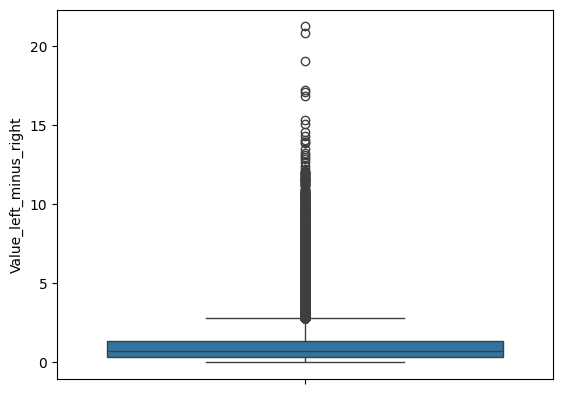

In [12]:
sns.boxplot(df_plot_ribs_join, y='Value_left_minus_right')

<Axes: ylabel='Value_left_minus_right'>

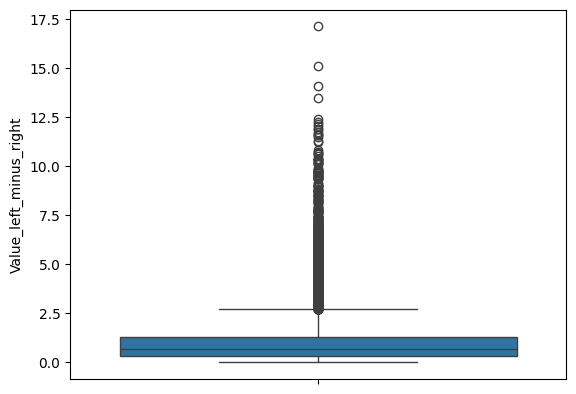

In [13]:
sns.boxplot(df_plot_ribs_join_2, y='Value_left_minus_right')

In [14]:
df_plot_ribs_stats = pd.DataFrame()
df_plot_ribs_join['filter_status'] = ['original'] * len(df_plot_ribs_join)
df_plot_ribs_join_2['filter_status'] = ['with_filters'] * len(df_plot_ribs_join_2)
df_plot_ribs_stats = pd.concat([df_plot_ribs_join, df_plot_ribs_join_2])

df_plot_ribs_stats.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,age,gender,findingSite_CodeMeaning,Value_left,Value_right,Value_left_minus_right,filter_status
0,132286,1.2.840.113654.2.55.69571713245519885935137963...,1.2.840.113654.2.55.10000830183123495604835259...,72,M,First rib,9.166992,7.344727,1.822265,original
1,107764,1.2.840.113654.2.55.17158622996185378565487542...,1.2.840.113654.2.55.10000850533416322553665072...,56,M,First rib,14.326782,14.005081,0.321701,original
2,128370,1.2.840.113654.2.55.26576277676425799146847962...,1.2.840.113654.2.55.10000944692524986099312741...,69,F,First rib,6.981753,8.832860,1.851107,original
3,129659,1.2.840.113654.2.55.14224315431907123431252487...,1.2.840.113654.2.55.10001102480903211454943302...,59,M,First rib,12.356180,12.444094,0.087914,original
4,123560,1.2.840.113654.2.55.19994432989699494147310497...,1.2.840.113654.2.55.10001275412896145078730823...,56,F,First rib,5.362366,5.485733,0.123367,original


In [15]:
# df_temp = df_plot_ribs_stats.iloc[0:20]

# Let's pick 20 patients
patient_id_list = list(set(df_plot_ribs_stats['PatientID'].values))
print(len(patient_id_list))
patient_id_list = patient_id_list[0:20000]
df_temp = df_plot_ribs_stats[df_plot_ribs_stats['PatientID'].isin(patient_id_list)]

print(len(df_temp))

26192
131274


In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming volumes_data is a DataFrame containing columns: patient_id, side (left/right), volume, and filter_status

# Fit linear mixed-effects model
mixed_model = smf.mixedlm("Value_left_minus_right ~ filter_status", df_temp, groups=df_temp["PatientID"])
mixed_results = mixed_model.fit()

# Print summary of results
print(mixed_results.summary())

                  Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Value_left_minus_right
No. Observations:    131274   Method:              REML                  
No. Groups:          20000    Scale:               0.2033                
Min. group size:     1        Log-Likelihood:      -113801.9450          
Max. group size:     36       Converged:           Yes                   
Mean group size:     6.6                                                 
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      0.980    0.007 144.585 0.000  0.967  0.994
filter_status[T.with_filters] -0.013    0.003  -4.132 0.000 -0.019 -0.007
Group Var                      0.868    0.022                            



In [17]:
# No observations is 115, correct
# No.Groups is 20, correct because we chose 20 patients
# Min group size and max group size seem correct - number of volumes per subject
# predicting the difference in left minus right - dependent variable
# filter status - P>[z] is large, at 0.328, which means there is not a significant difference between the original volumes and the filtered ones.

# try using more patients and see how this changes. as we increase to 1000 patients - the difference becomes significant.

## All rib pairs - left vs right differences

In [18]:
region_list = ["First rib" , "Second rib", "Third rib", "Fourth rib",  "Fifth rib", "Sixth rib",
               "Seventh rib",  "Eighth rib", "Ninth rib", "Tenth rib", "Eleventh rib",  "Twelfth rib"]
feature = "Volume from Voxel Summation"

df_plot_ribs_stats_all = pd.DataFrame()

for n in range(0,len(region_list)):
  region = region_list[n]
  print('*** region: ' + str(region) + ' ***')
  # df_plot_ribs_left = query_for_within_study_with_laterality(region, "Left", feature, table_id, project_name)
  # df_plot_ribs_right = query_for_within_study_with_laterality(region, "Right", feature, table_id, project_name)
  # df_plot_ribs_right = df_plot_ribs_right[['sourceSegmentedSeriesUID', 'Value']]
  # df_plot_ribs_temp = pd.merge(df_plot_ribs_left, df_plot_ribs_right, on='sourceSegmentedSeriesUID', how='left')
  # df_plot_ribs_temp = df_plot_ribs_temp.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  # df_plot_ribs_temp['region'] = [region_list[n]] * len(df_plot_ribs_temp)
  # df_plot_ribs = pd.concat([df_plot_ribs, df_plot_ribs_temp])
  # df_plot_ribs = get_organ_feature(region, feature, table_id, project_name)
  # only keep rows where for a sourceSegmentedSeriesUID and a region, both left and right exist

  # Original
  df_plot_ribs_temp = get_organ_feature(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join = df_plot_ribs_join[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join = df_plot_ribs_join.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_left'].values]
  df_plot_ribs_join['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join['Value_right'].values]
  df_plot_ribs_join['Value_left_minus_right'] = abs(df_plot_ribs_join['Value_left'].values - df_plot_ribs_join['Value_right'].values)

  # With heuristics
  df_plot_ribs_temp = get_organ_feature_with_segmentation_completeness(region, feature, table_id, project_name)
  df_plot_ribs_left_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Left"]
  df_plot_ribs_right_temp = df_plot_ribs_temp[df_plot_ribs_temp['laterality']=="Right"]
  df_plot_ribs_right_temp = df_plot_ribs_right_temp[['sourceSegmentedSeriesUID', 'Value']]
  df_plot_ribs_join_2 = pd.merge(df_plot_ribs_left_temp, df_plot_ribs_right_temp, on='sourceSegmentedSeriesUID', how='inner')
  df_plot_ribs_join_2 = df_plot_ribs_join_2[['PatientID', 'StudyInstanceUID', 'sourceSegmentedSeriesUID', 'age', 'gender',
                                        'findingSite_CodeMeaning', 'Value_x', 'Value_y']]
  df_plot_ribs_join_2 = df_plot_ribs_join_2.rename(columns={"Value_x": "Value_left", "Value_y": "Value_right"})
  df_plot_ribs_join_2['Value_left'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_left'].values]
  df_plot_ribs_join_2['Value_right'] = [np.float32(f)/1000.00 for f in df_plot_ribs_join_2['Value_right'].values]
  df_plot_ribs_join_2['Value_left_minus_right'] = abs(df_plot_ribs_join_2['Value_left'].values - df_plot_ribs_join_2['Value_right'].values)

  df_plot_ribs_stats = pd.DataFrame()
  df_plot_ribs_join['filter_status'] = ['original'] * len(df_plot_ribs_join)
  df_plot_ribs_join_2['filter_status'] = ['with_filters'] * len(df_plot_ribs_join_2)
  df_plot_ribs_stats = pd.concat([df_plot_ribs_join, df_plot_ribs_join_2])

  df_plot_ribs_stats_all = pd.concat([df_plot_ribs_stats_all, df_plot_ribs_stats])



*** region: First rib ***
*** region: Second rib ***
*** region: Third rib ***
*** region: Fourth rib ***
*** region: Fifth rib ***
*** region: Sixth rib ***
*** region: Seventh rib ***
*** region: Eighth rib ***
*** region: Ninth rib ***
*** region: Tenth rib ***
*** region: Eleventh rib ***
*** region: Twelfth rib ***


Try multiple ways to assess the difference between the left and right ribs

In [19]:
# Calculate the relative difference - ((left-right)/left) * 100
df_plot_ribs_stats_all['Value_relative_difference'] = np.abs(df_plot_ribs_stats_all['Value_left'].values - df_plot_ribs_stats_all['Value_right'].values) / df_plot_ribs_stats_all['Value_left'].values

In [20]:
# Or instead divide by the sum of the volumes
df_plot_ribs_stats_all['Value_relative_difference2'] = (np.abs(df_plot_ribs_stats_all['Value_left'].values - df_plot_ribs_stats_all['Value_right'].values)) / (df_plot_ribs_stats_all['Value_left'].values + df_plot_ribs_stats_all['Value_right'].values)

In [21]:
# Calculate the coefficient of variation - mean of left and right, divided by the standard deviation
temp = np.concatenate((np.expand_dims(df_plot_ribs_stats_all['Value_left'].values,1), np.expand_dims(df_plot_ribs_stats_all['Value_right'].values,1)), axis=1)
temp_mean = np.mean(temp, axis=1)
temp_std = np.std(temp, axis=1)
df_plot_ribs_stats_all['Coefficient_of_variation'] = (temp_std / temp_mean)

[Text(0.5, 0, 'Rib'),
 Text(0, 0.5, 'Absolute value of left minus right volume')]

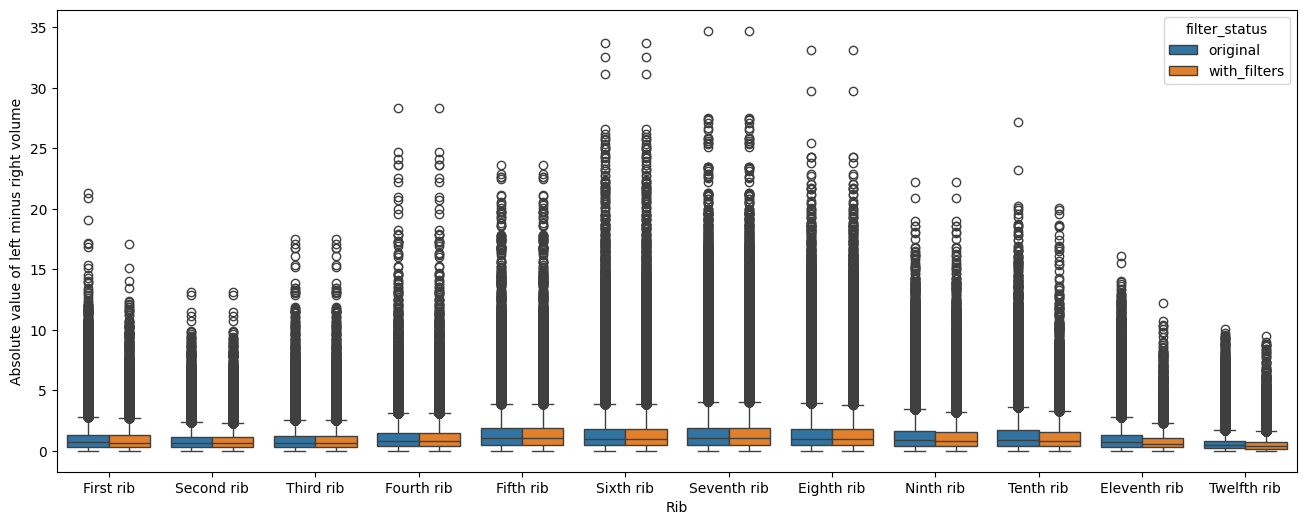

In [22]:
# Boxplots for
# x axis - rib, and with and without heuristic as the hue
# y axis - difference between left and right

plt.figure(figsize=(16,6))
ax = sns.boxplot(df_plot_ribs_stats_all, x='findingSite_CodeMeaning', y='Value_left_minus_right', hue='filter_status')
ax.set(xlabel='Rib', ylabel='Absolute value of left minus right volume')

[Text(0.5, 0, 'Rib'), Text(0, 0.5, 'Coefficient of variation')]

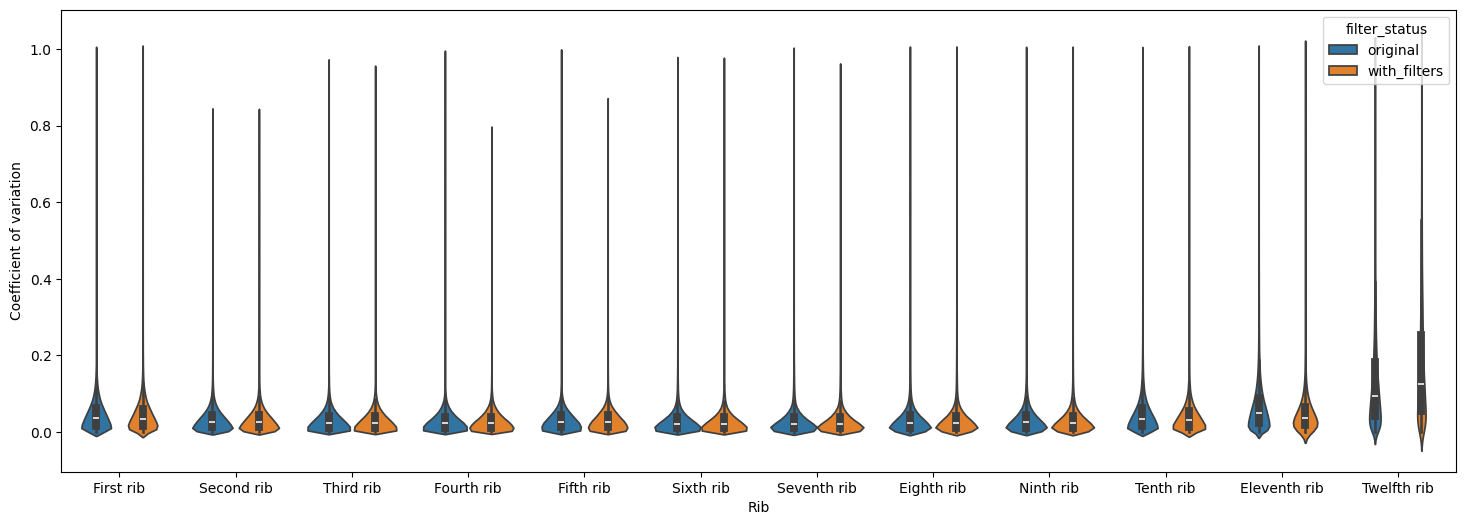

In [23]:
# Violin plot
# Coefficient of variation

plt.figure(figsize=(18,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all, x="findingSite_CodeMeaning", y="Coefficient_of_variation", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Coefficient of variation')

[Text(0.5, 0, 'Rib'),
 Text(0, 0.5, 'Normalized difference of left vs right rib')]

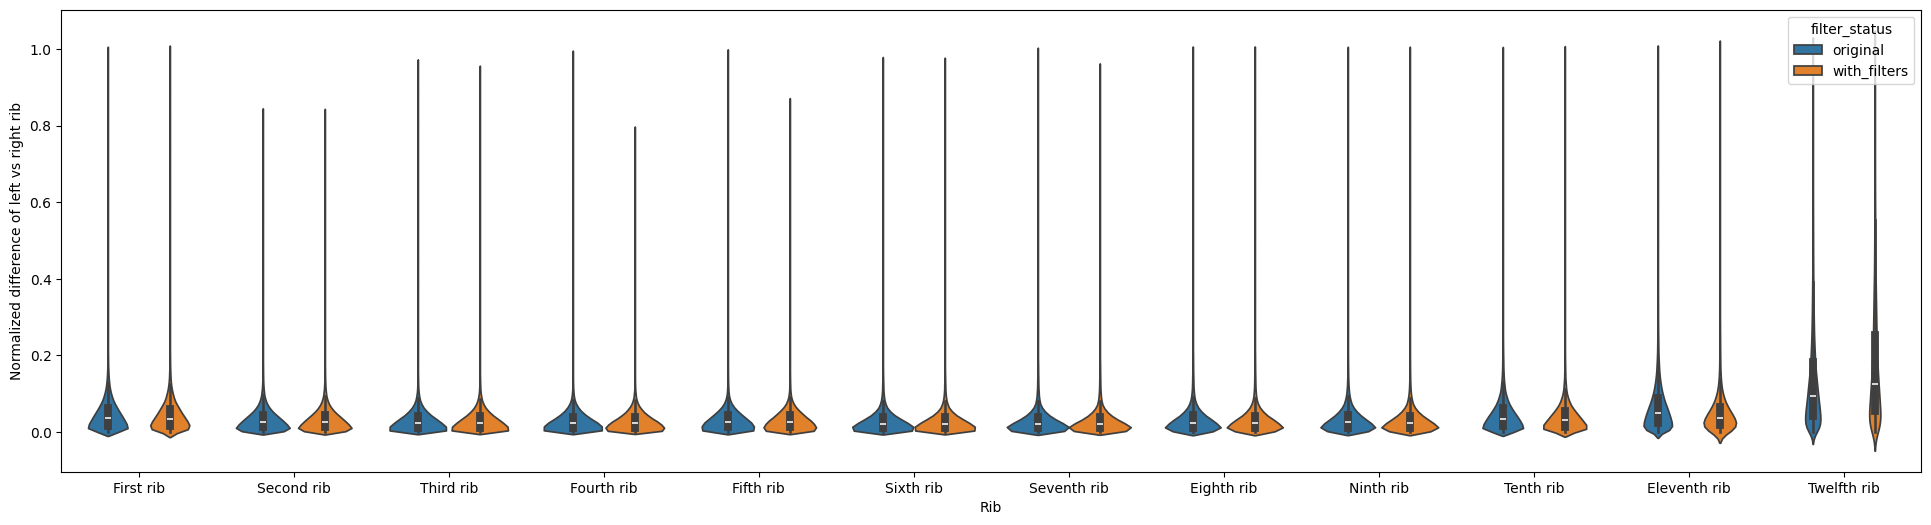

In [24]:
# Violinplot
# Normalized differences
# (left-right)/(left+right)

plt.figure(figsize=(24,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all, x="findingSite_CodeMeaning", y="Value_relative_difference2", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Normalized difference of left vs right rib')

[Text(0.5, 0, 'Rib'), Text(0, 0.5, 'Relative difference of left vs right rib')]

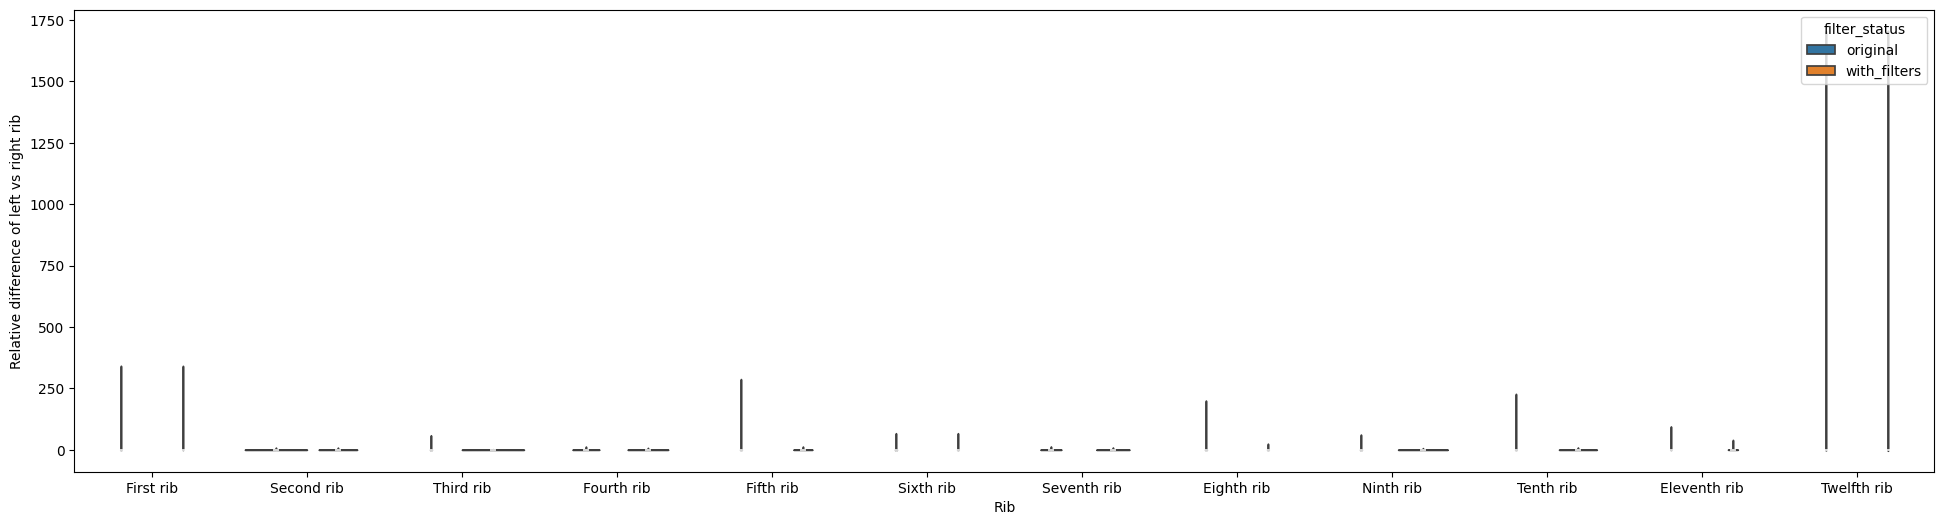

In [25]:
# Violin plot
# Plot the relative difference
# (left-right)/left

plt.figure(figsize=(24,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all, x="findingSite_CodeMeaning", y="Value_relative_difference", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Relative difference of left vs right rib')


[Text(0.5, 0, 'Rib'), Text(0, 0.5, 'Relative difference of left vs right rib')]

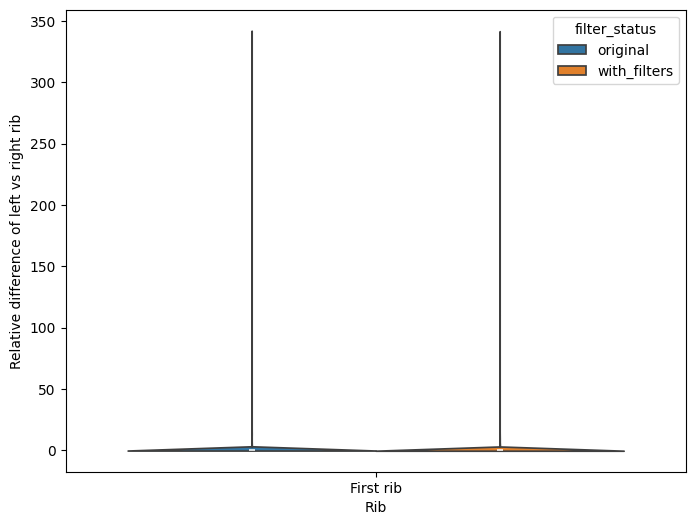

In [26]:
# Try with just one set of ribs, to see if any better...

df_plot_ribs_stats_all_first = df_plot_ribs_stats_all[df_plot_ribs_stats_all['findingSite_CodeMeaning']=="First rib"]

plt.figure(figsize=(8,6))
ax = sns.violinplot(data=df_plot_ribs_stats_all_first, x="findingSite_CodeMeaning", y="Value_relative_difference", hue="filter_status")
ax.set(xlabel='Rib', ylabel='Relative difference of left vs right rib')